# Price Prediction per State

* Extract data from the corresponding file.

In [4]:
import pandas as pd
df = pd.read_csv('housing_cleaned.csv')
df

id        region  price       type  sqfeet  beds  baths  \
0       7049044568  reno / tahoe   1148  apartment    1078     3    2.0   
1       7049047186  reno / tahoe   1200      condo    1001     2    2.0   
2       7043634882  reno / tahoe   1813  apartment    1683     2    2.0   
3       7049045324  reno / tahoe   1095  apartment     708     1    1.0   
4       7049043759  reno / tahoe    289  apartment     250     0    1.0   
...            ...           ...    ...        ...     ...   ...    ...   
340823  7049053337  reno / tahoe   1295  apartment     957     2    2.0   
340824  7049052968  reno / tahoe   1549  apartment    1034     2    2.0   
340825  7049050454  reno / tahoe   1249  apartment     840     2    1.0   
340826  7049050149  reno / tahoe   1429  apartment     976     2    2.0   
340827  7049050010  reno / tahoe   1295  apartment     957     2    2.0   

        cats_allowed  dogs_allowed  smoking_allowed  wheelchair_access  \
0                  1             1                0                  0   
1                  0             0                0                  0   
2                  1             1                1                  0   
3                  1             1                1                  0   
4                  1             1                1                  1   
...              ...           ...              ...                ...   
340823             1             1                1                  0   
340824             1             1                0                  0   
340825             1             1                1                  0   
340826             1             1                1                  0   
340827             1             1                1                  0   

        electric_vehicle_charge  comes_furnished  laundry_options  \
0                             0                0      w/d in unit   
1                             0                0      w/d hookups   
2                             0                0      w/d in unit   
3                             0                0      w/d in unit   
4                             0                1  laundry on site   
...                         ...              ...              ...   
340823                        0                0      w/d in unit   
340824                        0                0      w/d in unit   
340825                        0                0  laundry on site   
340826                        0                0      w/d in unit   
340827                        0                0      w/d in unit   

           parking_options      lat     long state  
0                  carport  39.5483 -119.796    ca  
1                  carport  39.5026 -119.789    ca  
2          attached garage  39.6269 -119.708    ca  
3                  carport  39.4477 -119.771    ca  
4                  Unknown  39.5357 -119.805    ca  
...                    ...      ...      ...   ...  
340823             carport  39.4477 -119.771    ca  
340824             Unknown  39.6269 -119.708    ca  
340825  off-street parking  39.5358 -119.746    ca  
340826             carport  39.5585 -119.703    ca  
340827             carport  39.4477 -119.771    ca  

[340828 rows x 18 columns]

* Count the amenities per listing. 

In [44]:
df['amenities_count'] = 0
amenities_columns = ['cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access',
                     'electric_vehicle_charge', 'comes_furnished']
df['amenities_count'] = df[amenities_columns].sum(axis=1)
df['amenities_count']

0         2
1         0
2         3
3         3
4         5
         ..
340823    3
340824    2
340825    3
340826    3
340827    3
Name: amenities_count, Length: 340828, dtype: int64

* Count the amenities with no values 0 or 1. Those are the parking option and the laundry option, where we examine the cases where their values are not 'no parking', 'Unknown' or 'Unknown', 'no laundry on site', correspondingly.

In [45]:
df['laundry_amenity'] = 0
non_amenities_laundry = ['Unknown', 'no laundry on site']
df.loc[~df['laundry_options'].isin(non_amenities_laundry), 'laundry_amenity'] = 1

df['parking_amenity'] = 0
non_amenities_parking = ['no parking', 'Unknown']
df.loc[~df['parking_options'].isin(non_amenities_parking), 'parking_amenity'] = 1

df['amenities_count'] += df[['laundry_amenity', 'parking_amenity']].sum(axis=1)
df = df.drop(['laundry_amenity', 'parking_amenity'], axis=1)
df['amenities_count']

0         4
1         2
2         5
3         5
4         6
         ..
340823    5
340824    3
340825    5
340826    5
340827    5
Name: amenities_count, Length: 340828, dtype: int64

### Linear Regression Model for Predicting Housing Prices by State

* This script aims to predict housing prices for different states using a linear regression model. The process involves:

#### 1. Data Preparation

- Calculating mean prices, amenities count, beds, baths, and square footage for each state from the input DataFrame `df`.
- Combining these mean values into a new DataFrame named `mean_values_df`.

#### 2. Model Training

- Training a linear regression model for each state using the mean values of amenities, beds, baths, and square footage as features and mean prices as the target variable.

#### 3. Prediction

- Creating a DataFrame `predicted_prices_df` containing the predicted prices for each state based on the trained models.

#### 4. Output

- Displaying the DataFrame with predicted prices for each state.

* This script provides a foundation for predicting housing prices based on various features for different states using linear regression.

In [30]:
from sklearn.linear_model import LinearRegression
import pandas as pd

mean_prices_by_state = df.groupby('state')['price'].mean()
mean_amenities_by_state = df.groupby('state')['amenities_count'].mean()
mean_beds_by_state = df.groupby('state')['beds'].mean()
mean_baths_by_state = df.groupby('state')['baths'].mean()
mean_sqfeet_by_state = df.groupby('state')['sqfeet'].mean()

mean_values_df = pd.DataFrame({
    'state': mean_prices_by_state.index,
    'mean_price': mean_prices_by_state.values,
    'mean_amenities': mean_amenities_by_state.values,
    'mean_beds': mean_beds_by_state.values,
    'mean_baths': mean_baths_by_state.values,
    'mean_sqfeet': mean_sqfeet_by_state.values,
})

models = {}
for state in mean_values_df['state']:
    state_data = mean_values_df[mean_values_df['state'] == state]
    
    X = state_data[['mean_amenities', 'mean_beds', 'mean_baths', 'mean_sqfeet']]
    y = state_data['mean_price']
    
    model = LinearRegression()
    model.fit(X, y)
    
    models[state] = model

features_df = mean_values_df[['mean_amenities', 'mean_beds', 'mean_baths', 'mean_sqfeet']]
predicted_prices = {}
for state, model in models.items():
    state_data = features_df[mean_values_df['state'] == state]
    X_state = state_data[['mean_amenities', 'mean_beds', 'mean_baths', 'mean_sqfeet']]
    predicted_prices[state] = model.predict(X_state)

predicted_prices_df = pd.DataFrame({
    'state': mean_values_df['state'],
    'predicted_price': [predicted_prices[state][0] for state in mean_values_df['state']]
})

print(predicted_prices_df)

   state  predicted_price
0     ak      1111.449001
1     al       872.435501
2     ar       836.137944
3     az      1020.596705
4     ca      1514.415515
5     co      1401.582469
6     ct      1269.845392
7     dc      1642.215313
8     de      1243.713085
9     fl      1172.202261
10    ga       934.997789
11    hi      1423.048193
12    ia       912.824933
13    id      1095.406968
14    il       893.206176
15    in       843.857595
16    ks       720.793664
17    ky       846.242371
18    la       923.266192
19    ma      1518.355117
20    md      1369.522283
21    me      1308.612245
22    mi       984.992089
23    mn      1127.946104
24    mo       731.242678
25    ms       794.487594
26    mt      1060.522132
27    nc       973.495251
28    nd       933.526898
29    ne       966.503358
30    nh      1551.525253
31    nj      1494.828477
32    nm       901.547887
33    nv      1105.850429
34    ny      1127.780795
35    oh       861.180205
36    ok       723.474019
37    or    

### Line Plot for Predicted Housing Prices by State

* This script generates a line plot to visualize the predicted housing prices for different states. Here is an overview:

#### 1. Sorting Predicted Prices

- Sorting the DataFrame `predicted_prices_df` by predicted prices in descending order.

#### 2. Line Plot Generation

- Creating a line plot with markers ('o') to represent predicted prices for each state.
- The x-axis represents the states, and the y-axis represents the predicted prices.
- The line is colored in blue, and markers are placed at each data point.

#### 3. Plot Customization

- Adding labels for the x-axis, y-axis, and the title of the plot.
- Rotating x-axis labels for better readability.
- Adjusting the layout for a visually appealing presentation.

#### 4. Display

- Displaying the generated line plot.

* This script provides a visual representation of predicted housing prices for different states using a line plot.

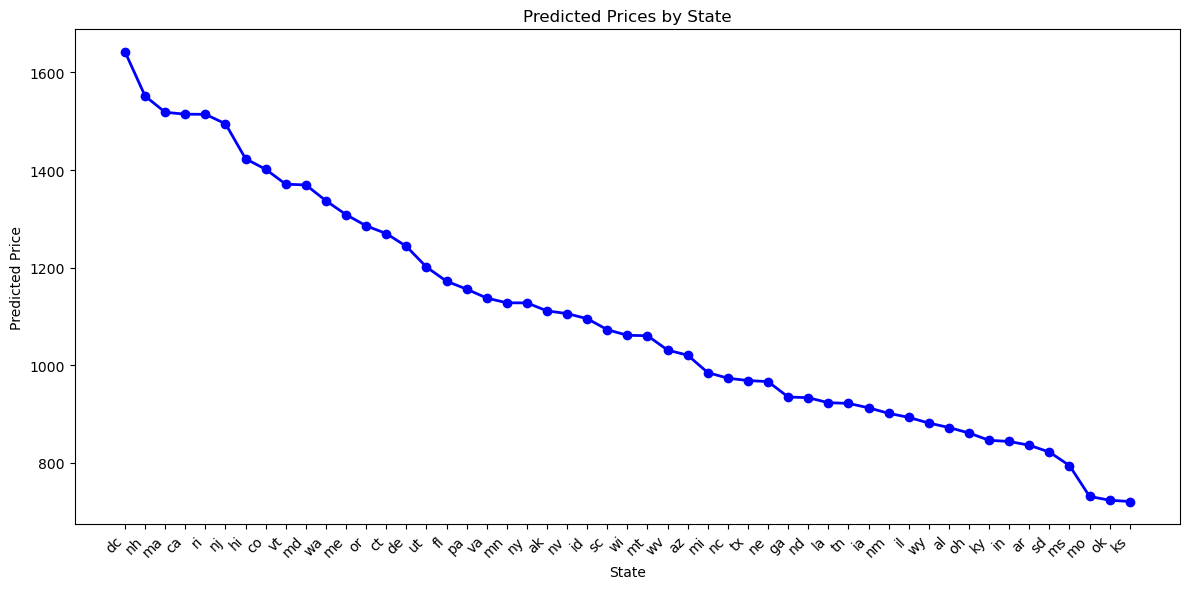

In [46]:
import matplotlib.pyplot as plt

predicted_prices_df_sorted = predicted_prices_df.sort_values(by='predicted_price', ascending=False)

plt.figure(figsize=(12, 6))

plt.plot(predicted_prices_df_sorted['state'], predicted_prices_df_sorted['predicted_price'], marker='o', color='blue', label='Predicted Price', linewidth=2)

plt.xlabel('State')
plt.ylabel('Predicted Price')
plt.title('Predicted Prices by State')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()

plt.show()